In [32]:
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from pathlib import Path

In [33]:
fp = "/home/Nele/code/ct_classifier_zoops/val_predictions_epoch_.json"
category_dict = json.load(open("/home/Nele/code/scripts/DataPrep_Classifier/category_dict.json", 'r'))
inverse_category_dict = {v: k for k, v in category_dict.items()}

Found 28 files to process.
Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00028.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00028.json


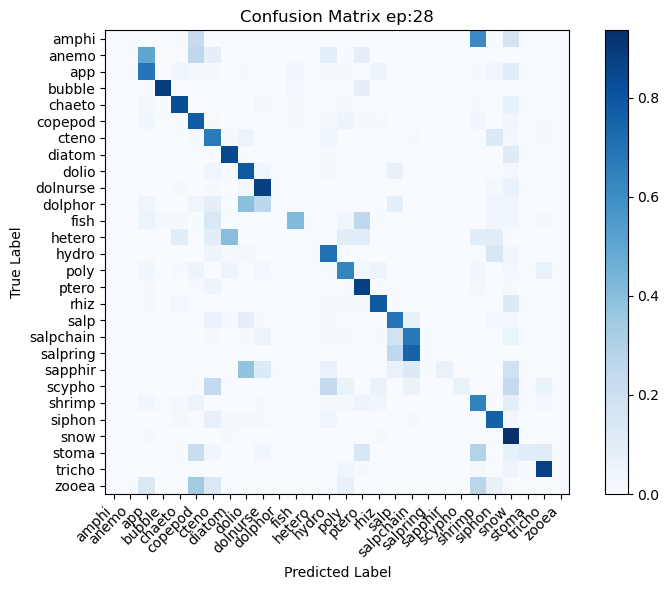

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00027.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00027.json


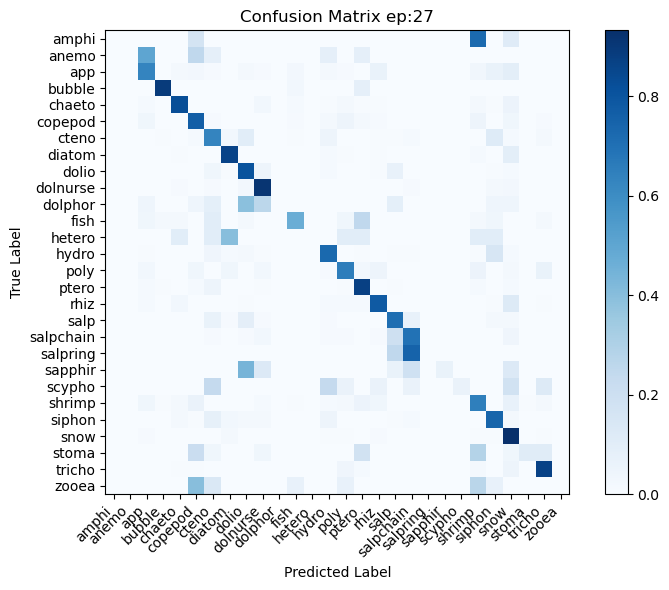

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00026.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00026.json


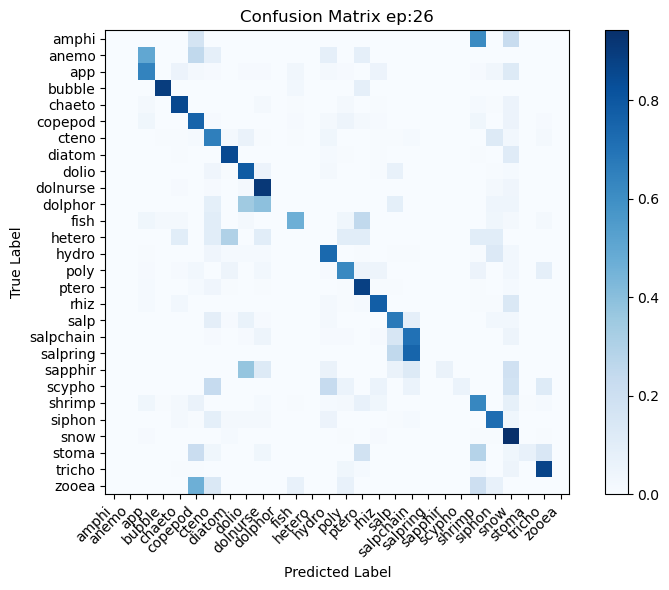

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00025.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00025.json


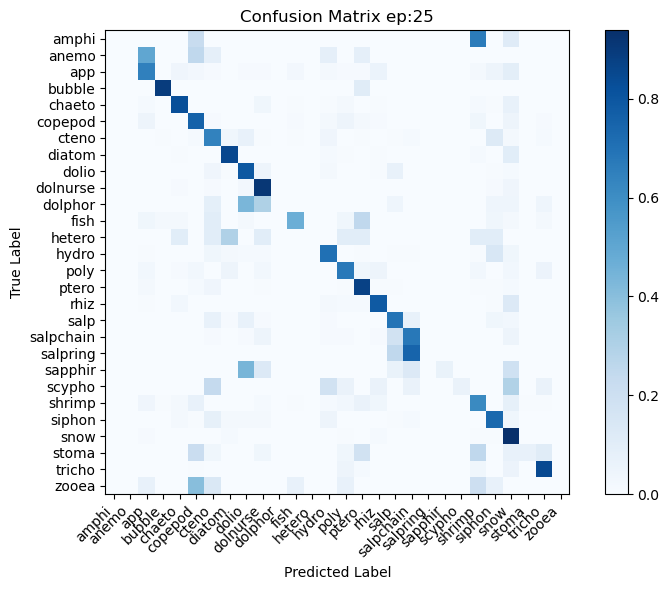

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00024.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00024.json


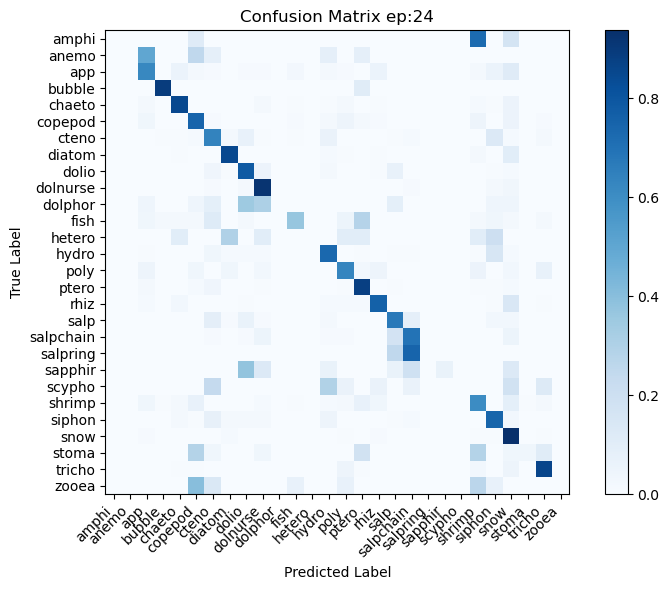

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00023.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00023.json


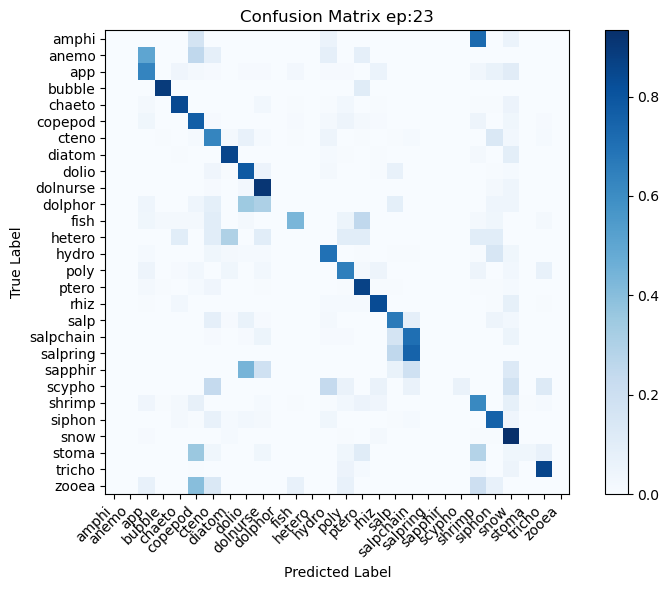

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00022.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00022.json


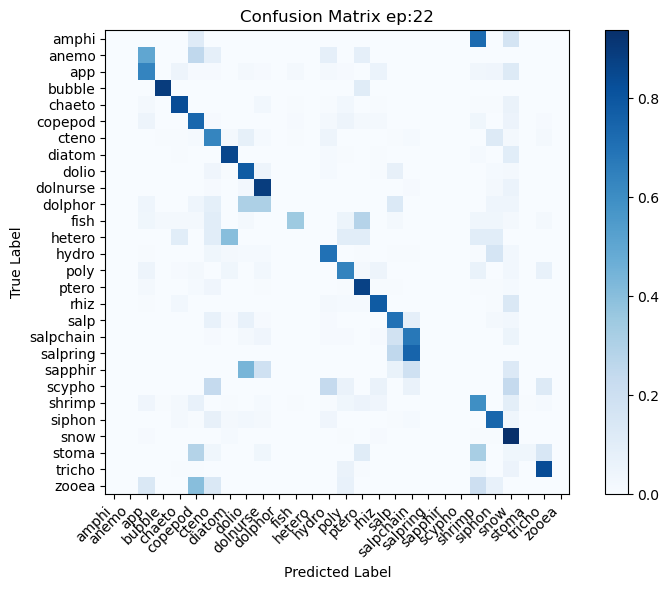

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00021.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00021.json


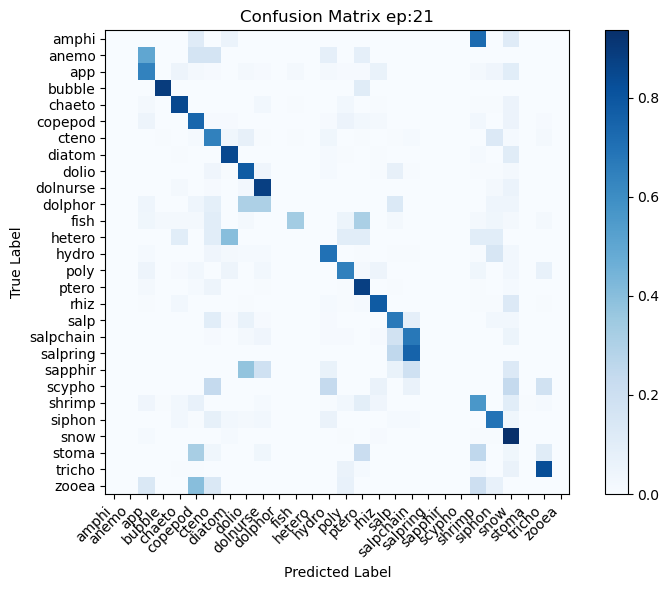

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00020.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00020.json


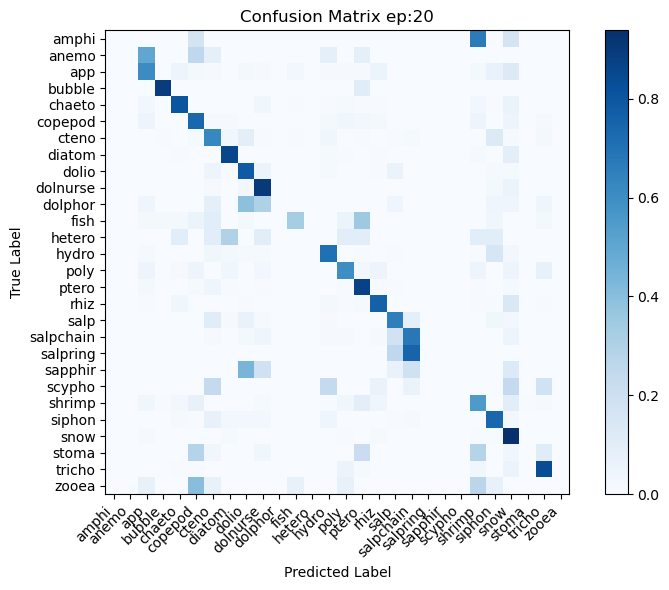

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00019.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00019.json


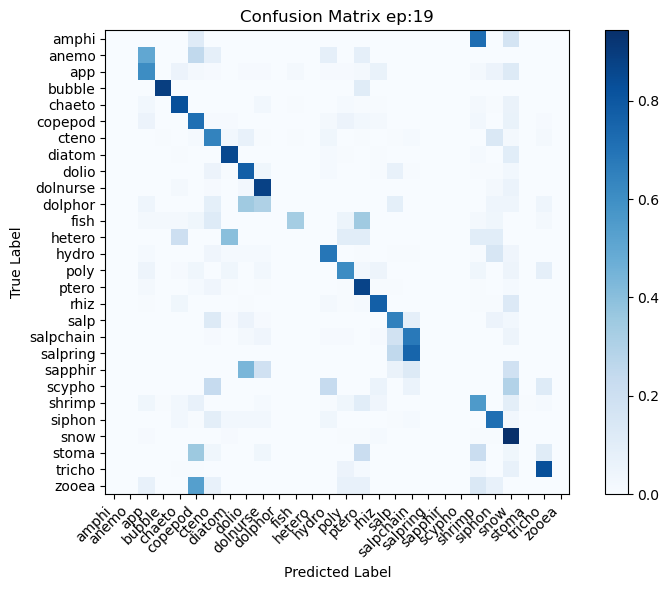

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00018.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00018.json


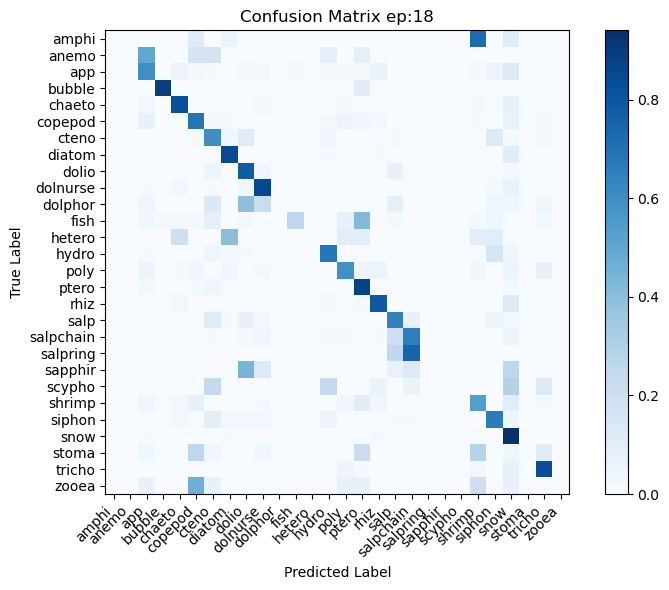

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00017.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00017.json


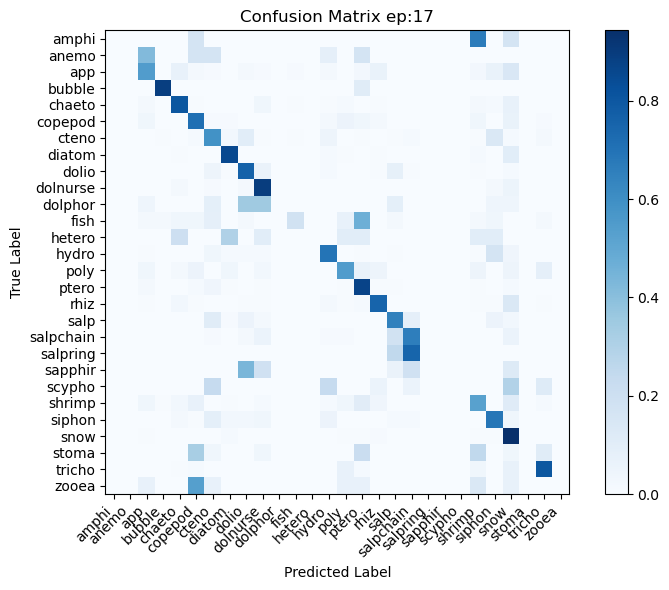

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00016.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00016.json


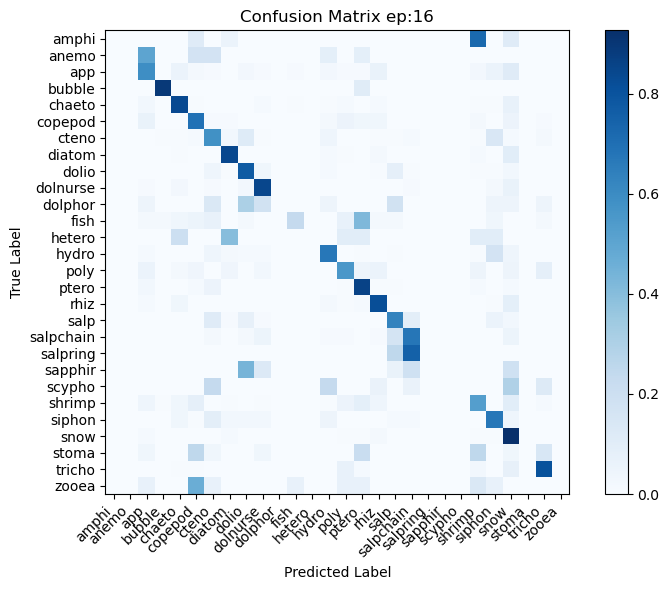

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00015.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00015.json


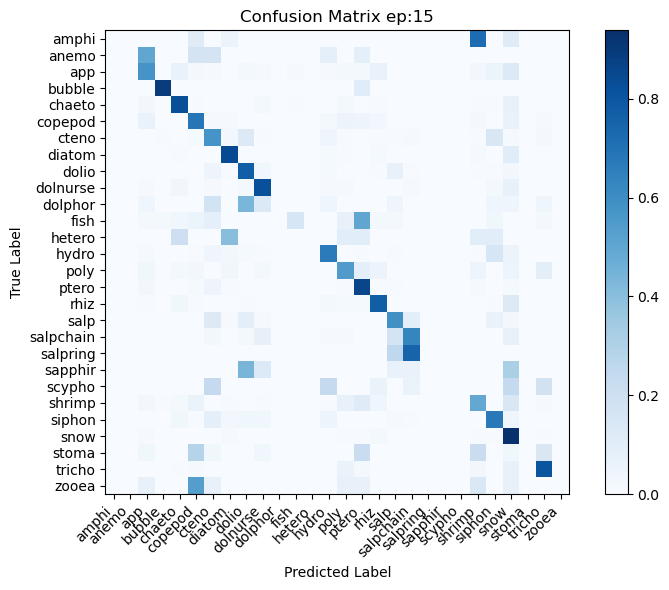

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00014.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00014.json


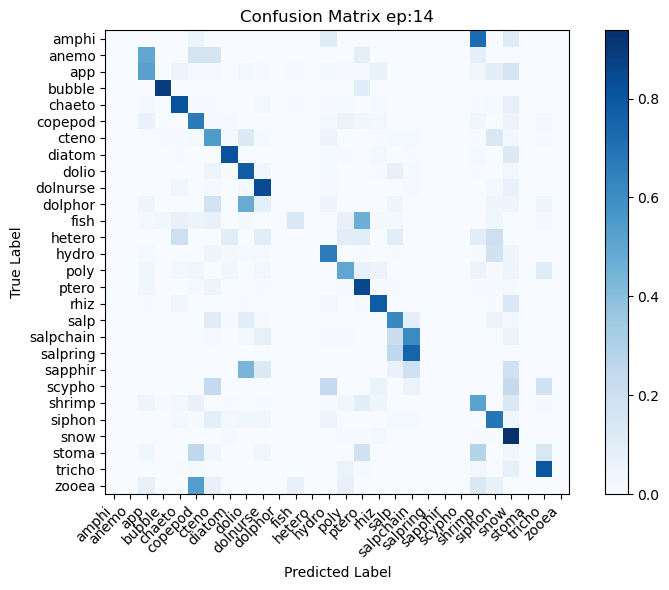

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00013.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00013.json


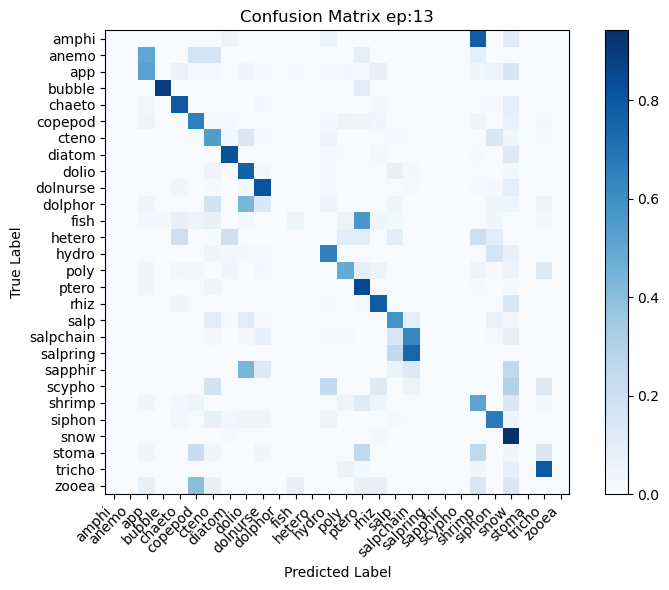

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00012.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00012.json


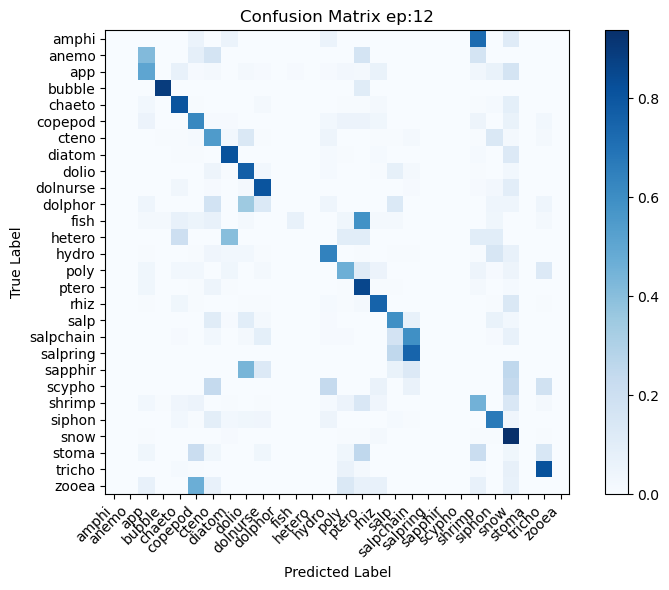

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00011.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00011.json


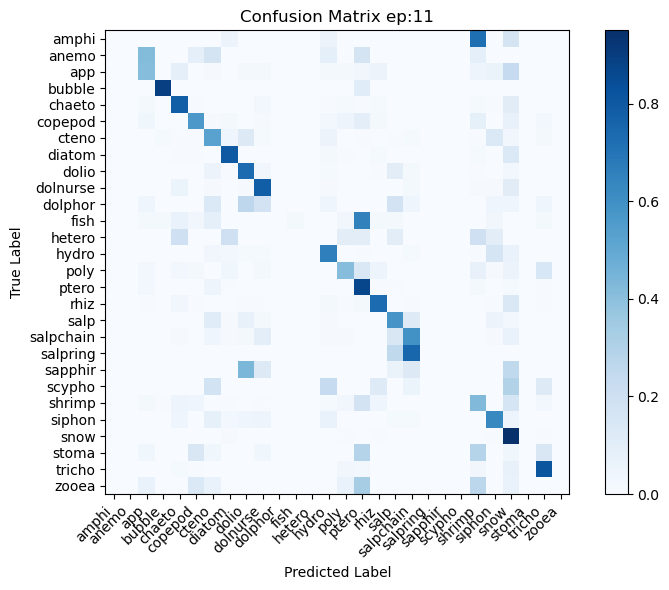

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00010.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00010.json


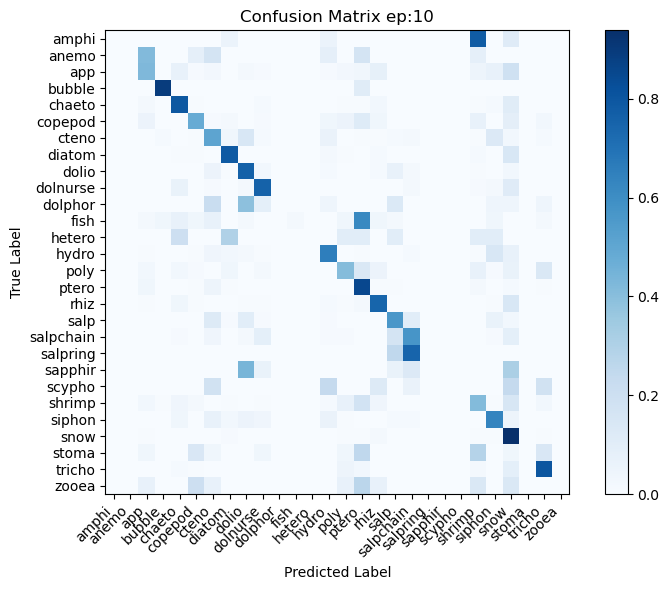

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00009.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00009.json


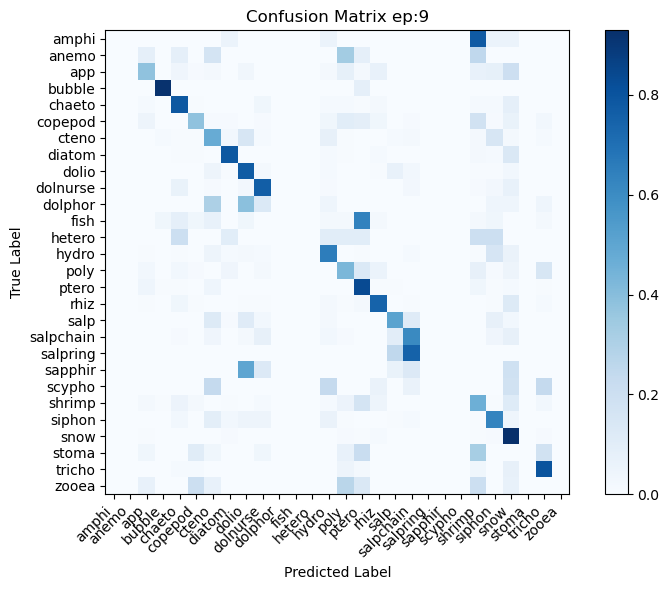

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00008.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00008.json


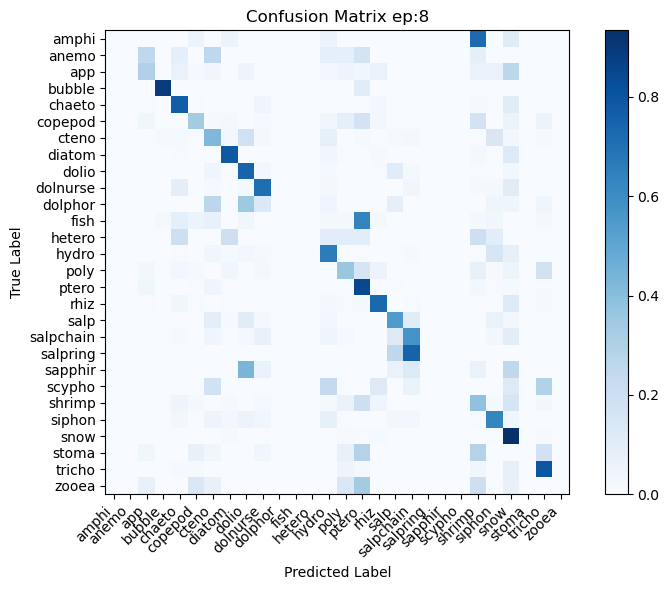

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00007.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00007.json


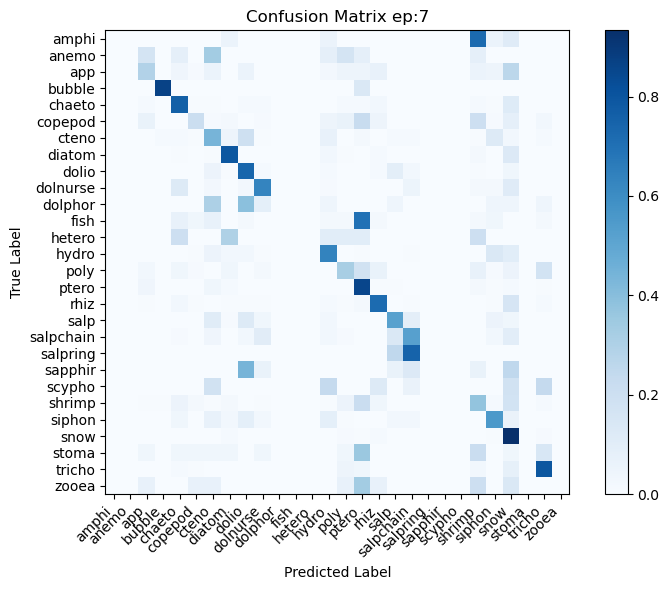

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00006.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00006.json


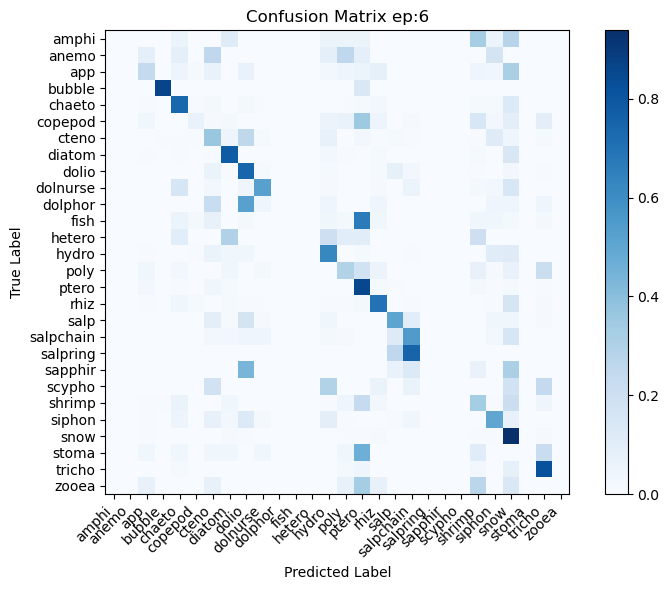

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00005.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00005.json


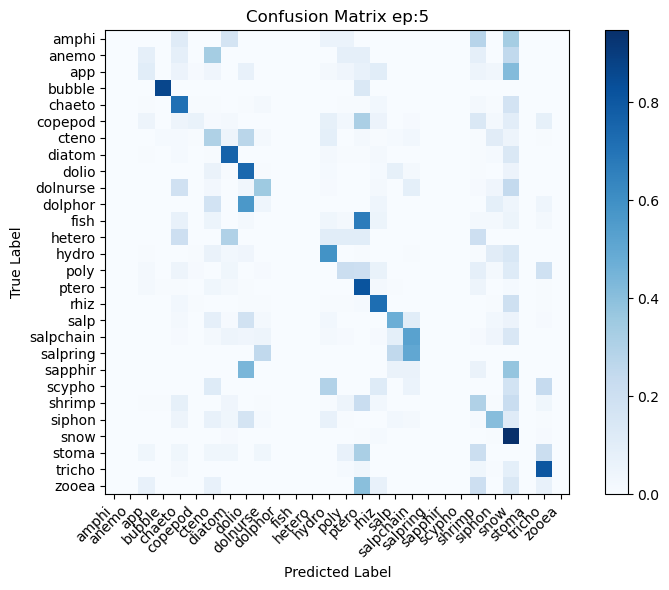

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00004.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00004.json


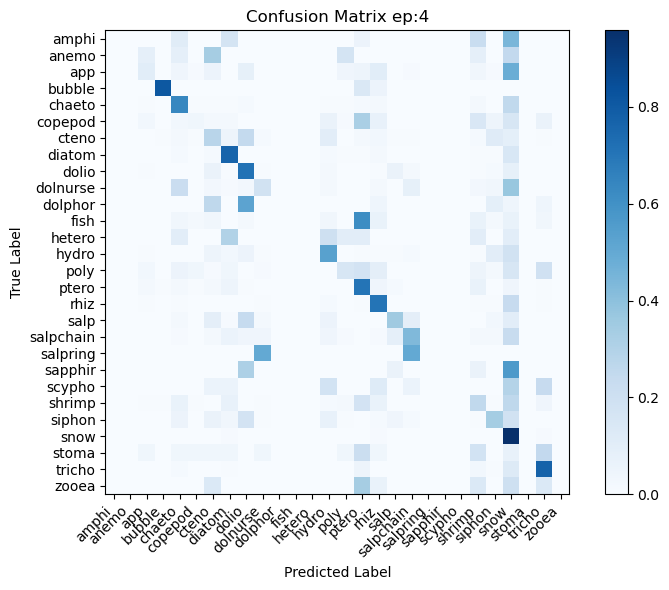

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00003.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00003.json


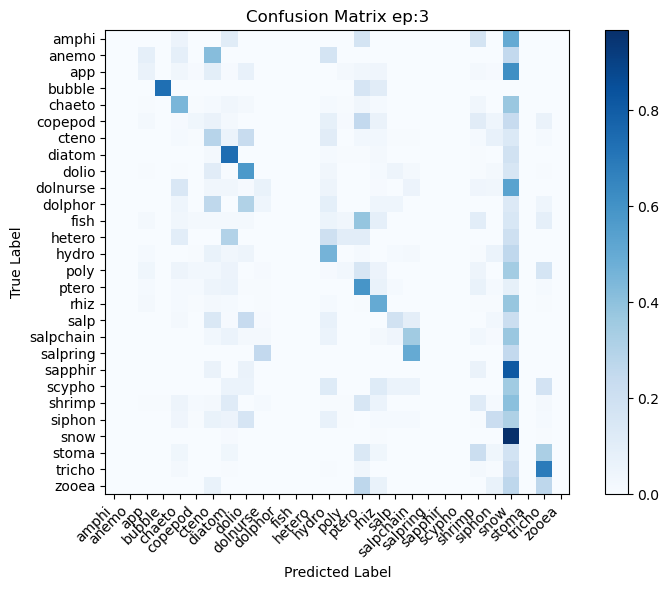

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00002.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00002.json


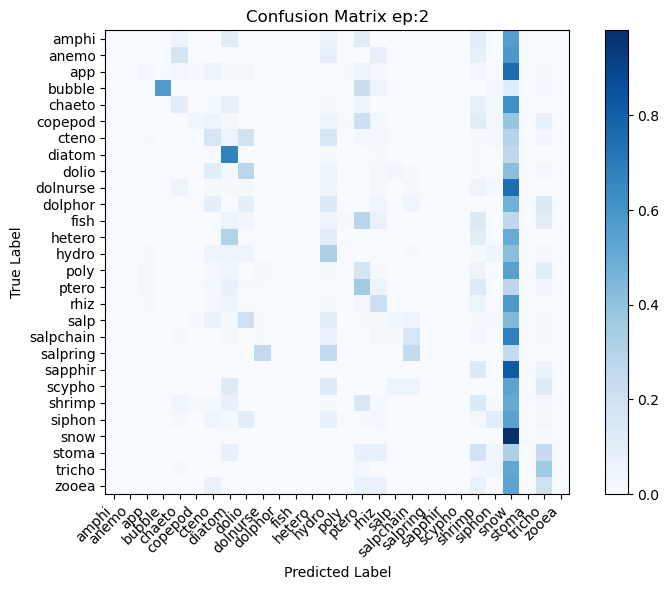

Processing file: /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00001.json /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions/val_predictions_epoch_00001.json


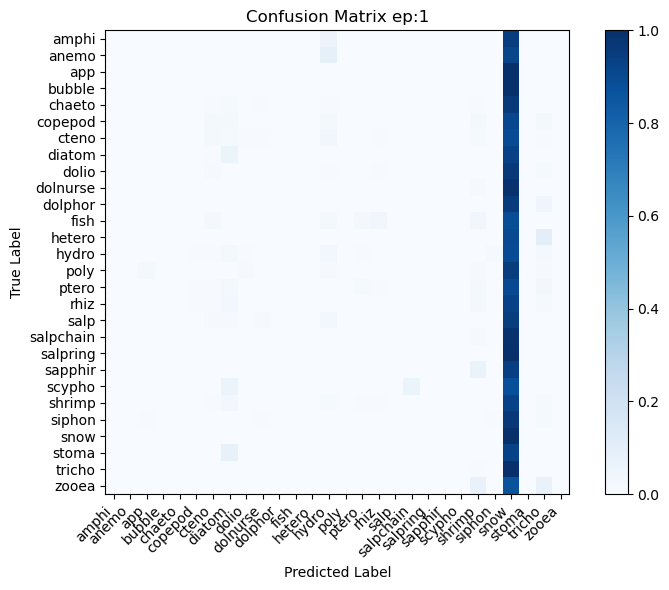

In [34]:
# load data from JSON file

# /home/Nele/code/ct_classifier_zoops/runs/Jan19_21-05-20_cv4e-2026-student4/val_predictions/val_predictions_epoch_2.json
# for i in [1,21,41,61,81, ]:

results_dir = Path("/home/Nele/code/ct_classifier_zoops/runs/Jan19_21-17-05_cv4e-2026-student4/val_predictions")
files = sorted(results_dir.glob("val_predictions_epoch_*.json"))
files = files[::-1]  # reverse order to start with last epoch
print(f"Found {len(files)} files to process.")
for f in files:
    fp = f"{results_dir}/{f.name}"
    ep_num_str = int(f.name.split('_')[-1].split('.')[0])
    print(f"Processing file: {fp} {f}")
    with open(fp, 'r') as f:
        data = json.load(f)
        predictions = data['predictions']
        ground_truths = data['labels']

    # convert lists to numpy arrays for easier manipulation
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    # plot confusion matrix normalised over true labels

    
    cm = confusion_matrix(ground_truths, predictions, normalize='true', labels=list(inverse_category_dict.keys()))
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ep:{ep_num_str}')
    plt.colorbar()
    tick_marks = np.arange(len(set(ground_truths)))
    plt.xticks(tick_marks, [inverse_category_dict[idx] for idx in tick_marks])
    # rotate x tick labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(tick_marks, [inverse_category_dict[idx] for idx in tick_marks])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    # plt.savefig('confusion_matrix.png')